# Access to S3 bucket for shared data

The Heavy Asset consortium shares access to a private AWS S3 bucket to persist large data assets across sessions and between users. EarthAI Notebook is set up to provide simple access to data stored on S3, raster data in particular.

The bucket is `sfi-shared-assets`. We can examine the top level keys (files or directories) on the bucket using the [AWS bash command](https://docs.aws.amazon.com/cli/latest/reference/s3/index.html#synopsis).

In [1]:
# Install aws command line if not already installed
! pip install awscli

In [2]:
! aws s3 ls sfi-shared-assets

                           PRE sample/


Here the `PRE` means that `sample` is a key prefix, and there are other keys that start with `sample`. 

We can also list the contents of the bucket using the [`boto3` Python library](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html). This is the official AWS Python API.

In [3]:
import boto3

s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

# list the first 10 objects
for o in bucket.objects.limit(10):
    print(o)
    if o.key[-4:] in ['.jp2', 'tif']:
        print(f's3://{o.bucket_name}/{o.key}')

s3.ObjectSummary(bucket_name='sfi-shared-assets', key='sample/35VLD_20200207_B03.jp2')
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2
s3.ObjectSummary(bucket_name='sfi-shared-assets', key='sample/stats.csv')


In [4]:
o.bucket_name

'sfi-shared-assets'

## Read object with RasterFrames

More on this topic can be found in the [RasterFrames documentation](https://rasterframes.io/raster-read.html) and in the EarthAI documentation relevant to reading [selected portions of larger rasters](https://docs.earthai.astraea.io/chip-intersecting-extent.html).


Importing EarthAI libraries.
EarthAI version 1.4.2; RasterFrames version 0.9.0.dev+astraea.1ce1ff3; PySpark version 2.4.4

Creating SparkSession...
  SparkSession is available as `spark`.


proj_raster_path,proj_raster
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2,
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2,
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2,
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2,
s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2,

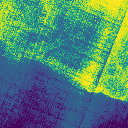
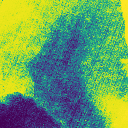
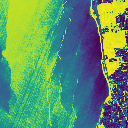
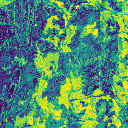
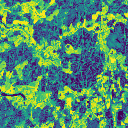

In [5]:
from earthai.init import * 

df = spark.read.raster('s3://sfi-shared-assets/sample/35VLD_20200207_B03.jp2')
df

## Put object on bucket

**Important**:  Writing directly to S3 from PySpark or RasterFrames, though technically possible, may be inefficient, expensive, or unreliable!  

Here we will create a small file on the notebook app's own "hard drive" and demonstrate how to put it on the bucket. 



In [6]:
df.groupby(rf_extent('proj_raster').xmin).agg(rf_agg_stats('proj_raster')) \
    .toPandas().to_csv('/tmp/example.csv')

In [7]:
! ls -l /tmp/example.csv

-rw-r--r-- 1 jovyan root 1040 Jul  8 20:31 /tmp/example.csv


In [8]:
bucket.upload_file('/tmp/example.csv', 'sample/stats.csv')

In [9]:
! aws s3 ls sfi-shared-assets/sample/

2020-02-25 01:30:16    2688965 35VLD_20200207_B03.jp2
2020-07-08 20:31:40       1040 stats.csv


# Delete an object forever

There's no undo!

You can either use the bash `aws s3 rm` or `boto3`.

In [10]:
!aws s3 rm --help

usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help
aws: error: the following arguments are required: paths


In [13]:
if False:  # safety key to avoid accidentally deleting a bunch of stuff, set to True to run
    for o in bucket.objects.filter(Marker='sample/', MaxKeys=3):
        if 'stats.csv' in o.key:
            print(f'Deleting s3://{o.bucket_name}/{o.key} forever!')
            o.delete()
else: 
    print("No boto3 code evaluated")

Deleting s3://sfi-shared-assets/sample/stats.csv forever!


In [14]:
! aws s3 ls sfi-shared-assets/sample/

2020-02-25 01:30:16    2688965 35VLD_20200207_B03.jp2
